## Starting again with stuff from Hao's notebook ##

In [4]:
!pip install psycopg2

In [1]:
import sys
import pandas as pd
import numpy as np
import datetime
sys.path.append('..\\sif_research\\research_framework')
import metrics
import os
from operators import rank, ts_rank, group_rank, weight


sys.path.append('..\\sif_research\\data_utils')

import sif_utils as su

In [2]:
# Global Variables / Research Environment Settings
start_date = datetime.datetime(day=1, month=1, year=2012)
end_date = datetime.datetime(day=1, month=1, year=2017)
days = (end_date - start_date).days
lookback = 20
delay = 1
top_N = 300
initial_investment = 1000
save_backtest_result = True
backtest_result_folder = './backtest_result'
# Get all tickers
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))

In [3]:
# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)

price_attrs = ['open', 'close', 'low', 'high', 'volume']
data = su.get_equity_data(tickers=tickers, start_date=start_date,
                          end_date=end_date, attributes=price_attrs)


In [4]:
OPEN = data['open'].astype(float).values
CLOSE = data['close'].astype(float).values
LOW = data['low'].astype(float).values
HIGH = data['high'].astype(float).values
VOLUME = data['volume'].astype(float).values

# Create universe filter table
all_dates = data['close'].index.values
universe_filter = su.create_universe_filter(top_N, start_date, end_date, tickers, all_dates)

# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)
universe_filter_arr = universe_filter.values

In [5]:
data.keys()

dict_keys(['open', 'close', 'low', 'high', 'volume'])

In [6]:
# Hao's example alpha
def alpha(day):
    # raw factor computed for all tickers (not necesarily the valid universe)
    factor = -rank(CLOSE[day - delay] - CLOSE[day - delay - 4])
    return weight(factor, universe_filter_arr[day])

In [11]:
# The idea of combining gain and acceleration to estimate future returns
# If a stock has had positive returns and is 
def momentum_alpha(day, gain_lb=4, acc_lb=18):
    acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
    weekly_gain = -rank(CLOSE[day - delay] - CLOSE[day - delay - gain_lb])
    
    factor = weekly_gain + acceleration
    return weight(factor, universe_filter_arr[day])

In [13]:
def test_diff_lookbacks(gain_lbs=[4], acc_lbs=[18]):
    for gain_lb in gain_lbs:
        for acc_lb in acc_lbs:
            def momentum_alpha(day):
                acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
                weekly_gain = -rank(CLOSE[day - delay] - CLOSE[day - delay - gain_lb])

                factor = weekly_gain + acceleration
                return weight(factor, universe_filter_arr[day])
            # run backtest, print the performance table and draw the chart
            # For skew momentum
            lookback = 20
            holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
            daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
            performance = metrics.generate_performance_table(daily_returns, holdings,
                                                             dates=all_dates[lookback:-1],
                                                            tickers=tickers)
            print(f'Gain lb: {gain_lb}, Acc lb: {acc_lb}')
            rets = performance['return'].iloc[5]
            shp = performance['sharpe'].iloc[5]
            srt = performance['sortino'].iloc[5]
            trn_ovr = performance['turnover'].iloc[5]
            print(f'Total returns: {rets} , Sharpe: {shp} , Sortino: {srt}, Turnover {trn_ovr}')

            
gain_lbs=[3, 4, 5, 6, 7, 8, 9, 10]
acc_lbs=[10,12,13,14,15,16,17,18,20,25,30, 35, 40]
test_diff_lookbacks(gain_lbs, acc_lbs)


# pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
# chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


Gain lb: 3, Acc lb: 10
Total returns: 0.19488975560502164 , Sharpe: 1.0734992428185743 , Sortino: 1.6154413928153628, Turnover 0.7808227605847979
Gain lb: 3, Acc lb: 12
Total returns: 0.1854971657153981 , Sharpe: 1.0241030610842483 , Sortino: 1.5432000146514735, Turnover 0.7556459231708186
Gain lb: 3, Acc lb: 13
Total returns: 0.17577622663339082 , Sharpe: 0.9664216142418761 , Sortino: 1.444622887150427, Turnover 0.747793227861756
Gain lb: 3, Acc lb: 14
Total returns: 0.16832539792096965 , Sharpe: 0.9319843787054403 , Sortino: 1.4029103737589335, Turnover 0.7375338072594825
Gain lb: 3, Acc lb: 15
Total returns: 0.16435377449834151 , Sharpe: 0.8956993459419518 , Sortino: 1.3409530178027533, Turnover 0.7310284748780652
Gain lb: 3, Acc lb: 16
Total returns: 0.16243967912407323 , Sharpe: 0.888596306596429 , Sortino: 1.339644861334922, Turnover 0.720556977715385
Gain lb: 3, Acc lb: 17
Total returns: 0.17734775295533844 , Sharpe: 0.9716320993736192 , Sortino: 1.4756580392757856, Turnover 0.7

In [35]:
def skew_momentum_alpha(day):
    # Using the max daily return from the past 3 months to represent skew
#     print(day)
    skew_start = day - delay - 20
    skew_end = day
#     print(f'Skew start: {skew_start} , skew end: {skew_end}')
    daily_rets = CLOSE[skew_start:skew_end] - OPEN[skew_start:skew_end]
    
    skew = rank(np.amax(daily_rets, axis=0))

    # Using return from the past 3 months as momentum
    momentum = rank(CLOSE[day - delay] / CLOSE[day - delay - 252])

    # We believe that stocks with either high skew and negative momentum OR stocks with low skew and positive momentum are the stocks we want to long
    # These stocks are said to have "enhanced momentum"
    # High skew neg momentum signifies a stock that is currently undervalued?, as in its current pricing represents a negative outlier value and it will revert to the mean
    # Low skew pos momentum signifies a stock that is currently performing well and appears to be performing around its average, therefore this stock is a good buy as 
    #    we expect it to continue on this trend

    # Simple and likely nonoptimal way to try to find these stocks with mixed skew/momentum high/low or low/high is to add their ranked arrays together
        # Side note, could weight the momentum vs. skew arrays differently to see if that changes anything
    # Since the rankings are both equal, (rank assigns a percentile to each ticker), The combination of skew/momentum high/high will be closer to 2 and low/low will be closer to 0, 
    # so we want middling values

    # In a simple effort to address this, we rank the values in the combined array of skew and momentum by each elements absolute difference from 1
    # (i.e. -rank by abs diff to ensure that the lowest abs diff is ranked highest)
#         combined = skew + momentum
#     #     print(combined)
#         factor = -rank(abs(combined - 1))
#         return weight(factor, universe_filter_arr[day])

    # Trying paper's approach for ranking
    # Take stocks that are in the top quintile of skew and bottom quintile of momentum or in the bottom quintile of skew and top quintile of momentum
    factor = np.zeros(len(skew))
#     print(skew)
#     print(momentum)
    for i in range(0, len(skew)):
        if((skew[i] >= .8 and momentum[i] <= .2) or (skew[i] <= .2 and momentum[i] >= .8)):
            # Long the stock
            factor[i] = abs(skew[i] - momentum[i])
        else:
            factor[i] = 0
    # Inverting the factor gives much better returns???
    # Did I get something backwards???
    return weight(factor, universe_filter_arr[day])

In [ ]:
# The idea is to include returns, change in returns, and change in change in returns as stats to look at 
def convex_concave(day):
    

In [13]:
def long_all(day):
    all_long = np.zeros(318)
    all_long.fill(1/300)
    return all_long

In [34]:
skew_momentum_alpha(346)

array([ 0.        , -0.00180505, -0.00180505,  0.        ,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        ,  0.        ,
        0.        , -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505, -0.00180505,  0.02173913, -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
        0.        ,  0.        , -0.00180505, -0.00180505,  0.        ,
       -0.00180505,  0.        ,  0.02173913, -0.00180505, -0.00180505,
        0.        , -0.00180505, -0.00180505, -0.00180505,  0.02173913,
        0.        , -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.02173913, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
       -0.00180505, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.        , -0.00180505,  0.        ,  0.02173913, -0.00

In [ ]:
# POSITIVE LOOKING NUMBERS
# Gain lb: 4, Acc lb: 18
# Total returns: 0.2382934958199166 , Sharpe: 1.2804265794353327 , Sortino: 1.9797770886920847, Turnover 0.6521009895640726
# Gain lb: 4, Acc lb: 20
# Total returns: 0.20310126440176596 , Sharpe: 1.0802058985497824 , Sortino: 1.6555270393783252, Turnover 0.640640241958349
# Gain lb: 4, Acc lb: 25
# Total returns: 0.21252520383274218 , Sharpe: 1.1269014278882434 , Sortino: 1.7166351306188292, Turnover 0.6196802022986341
# Gain lb: 4, Acc lb: 30
# Total returns: 0.23246141204533602 , Sharpe: 1.2382039738994808 , Sortino: 1.9045470095089285, Turnover 0.6023572866546534

In [80]:
# Can do something with close to open overnight
def overnight(day):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-80-d8fb8771adf2>, line 3)

### Some notes from meeting 2/24/2020 to possibly make alphas ### 

 Momentum again from video from 2/24/2020
 
 Look at convexity and concavity
 
 y = Gain * t + Acc * x^2
 
 Accelerated vs decelerated gain
 
 Whether coefficients are positive or negative
 
 Approximating curves with polynomials

 Skewness and momentum
 Skewness as a signal for stocks that are overbrought

Proxy for skew, max daily return from past 20 days/ past month (positive skew)
    Could also do negative skew with minimum

Assume return over trailing year as momentum

More strongly positive skew and positive momentum represents weakened momentum

Positive momentum and less skew is enhanced momentum

Negativee momentum and positive skew is enhanced momentum

Negative momenutum and less skew is weakened momentum

Ideas for fundamanetal frm Hao
   
   Rank ( equity/ assets) <-- cross sectional
   
   ts_rank(-debt/equity, 252 <-- or whatever lookback) <-- ts_info
   
   abs(eps[day - 1] - eps[day - 2]) > 0 <-- check to see if comany updated financial statements
   
       Include mean reversion/momentum factor and combine with this to build an alpha

           return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2012     0.052803  1.439421  2.242393 -0.026898  0.653978  146.339130   
2013     0.019707  0.806433  1.214047 -0.035052  0.643378  144.920635   
2014     0.052829  1.416770  2.319034 -0.029982  0.650103  144.059524   
2015     0.060655  1.546073  2.410922 -0.010753  0.671630  144.174603   
2016     0.057135  1.189885  1.776844 -0.034469  0.637317  142.079681   
Overall  0.238293  1.280427  1.979777 -0.033883  0.652101  144.277060   

         short count  
year                  
2012      152.608696  
2013      153.678571  
2014      153.769841  
2015      151.773810  
2016      146.035857  
Overall   151.554120  


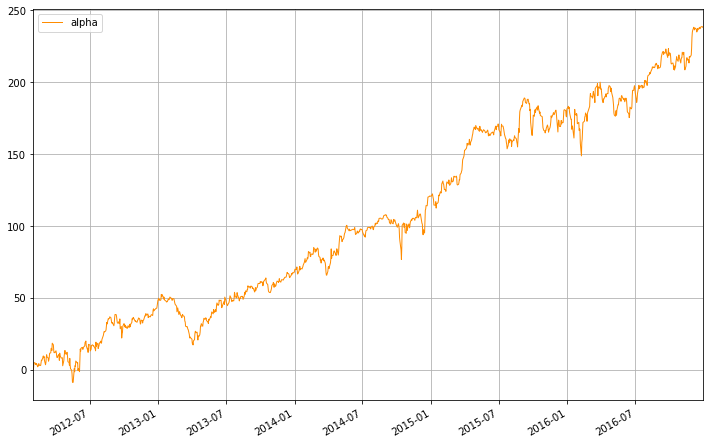

In [12]:
# run backtest, print the performance table and draw the chart
# For skew momentum
lookback = 20
holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
performance = metrics.generate_performance_table(daily_returns, holdings,
                                                 dates=all_dates[lookback:-1],
                                                tickers=tickers)
print(performance)
# print(performance['return'].iloc[5])
pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


In [16]:
# save backtest result
if save_backtest_result == True:
    if not os.path.exists(backtest_result_folder):
        os.makedirs(backtest_result_folder)
    pnl_df.to_csv(backtest_result_folder+'/'+'pnl.csv')
    pd.DataFrame(holdings[:-1],index = data['close'].iloc[lookback:-1].index, columns = tickers).to_csv(backtest_result_folder+'/'+'holdings.csv')
    chart.get_figure().savefig(backtest_result_folder+'/'+'performance.png')
        